In [7]:
using Revise
using DrWatson

In [8]:
@quickactivate :ReactiveMPPaperExperiments

In [9]:
using ReactiveMP, Rocket, GraphPPL, Distributions, Random
using CairoMakie
using BenchmarkTools, DataFrames, Query

import ReactiveMP: update!

┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1342
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1342


### Hierarchical Gaussian Filter

In this demo the goal is to perform approximate variational Bayesian Inference for Univariate Hierarchical Gaussian Filter (HGF).

Simple HGF model can be defined as:

$$
\begin{equation}
  \begin{aligned}
    x^{(j)}_k & \sim \, \mathcal{N}(x^{(j)}_{k - 1}, f_k(x^{(j - 1)}_k)) \\
    y_k & \sim \, \mathcal{N}(x^{(j)}_k, \tau_k)
  \end{aligned}
\end{equation}
$$

where $j$ is an index of layer in hierarchy, $k$ is a time step and $f_k$ is a variance activation function. `ReactiveMP.jl` export Gaussian Controlled Variance (GCV) node with $f_k = \exp(\kappa x + \omega)$ variance activation function. By default uses Gauss-Hermite cubature with a prespecified number of approximation points in the cubature. We can change the number of points in Gauss-Hermite cubature with the help of metadata structures in `ReactiveMP.jl`. 

$$
\begin{equation}
  \begin{aligned}
    z_k & \sim \, \mathcal{N}(z_{k - 1}, \mathcal{\tau_z}) \\
    x_k & \sim \, \mathcal{N}(x_{k - 1}, \exp(\kappa z_k + \omega)) \\
    y_k & \sim \, \mathcal{N}(x_k, \mathcal{\tau_y})
  \end{aligned}
\end{equation}
$$

In this experiment we will create a single time step of the graph and perform variational message passing filtering alrogithm to estimate hidden states of the system.

For simplicity and smooth reactive graphs we will consider $\tau_z$, $\tau_y$, $\kappa$ and $\omega$ known and fixed.

### Data

For testing purposes we can use synthetically generated data where underlying data generation process matches our model specification.

In [10]:
params = let 
    
    seed = 122
    
    n    = 250
    τ_z  = 20.0
    τ_y  = 100.0
    
    κ = 1.0
    ω = 0.0
    
    # for inference later
    nitr = 20
    gh_n = 51

    @strdict seed n τ_z τ_y κ ω nitr gh_n
end;

In [11]:
z, s, y = generate_data(HGFModel(), params);

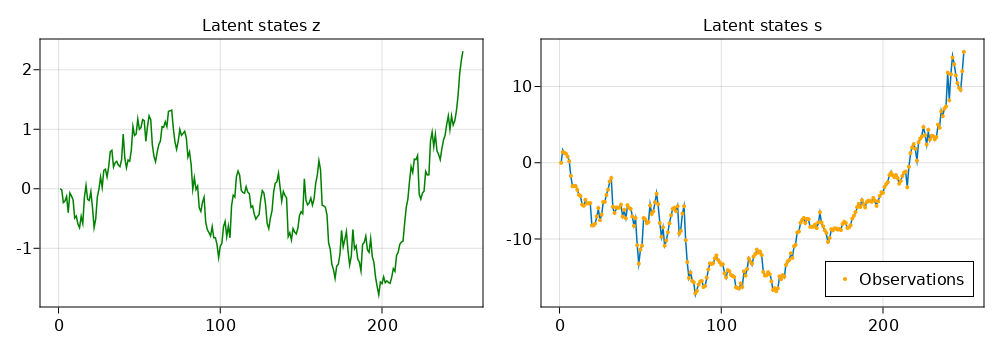

In [12]:
let 
    f = Figure(resolution = (1000, 350))
    
    range = 1:length(z)
    
    ax1 = Axis(f[1, 1], title = "Latent states z")
    ax2 = Axis(f[1, 2], title = "Latent states s")
    
    lines!(ax1, range, z, color = :green)
    
    lines!(ax2, range, s)
    scatter!(ax2, range, y, label = "Observations", markersize = 4, color = :orange)
    
    axislegend(ax2, position = :rb)
    
    f
end

### Model specification

In [13]:
@model function hgf(gh_n, τ_z, τ_y, κ, ω)

    # First as usual we create a placeholder inputs for our priors
    zv_prior = datavar(Float64, 2)
    sv_prior = datavar(Float64, 2)

    zv_min ~ NormalMeanPrecision(zv_prior[1], zv_prior[2])
    sv_min ~ NormalMeanPrecision(sv_prior[1], sv_prior[2])

    # Z-layer random walk 
    normalnode ,zv ~ NormalMeanPrecision(zv_min, τ_z) where { q = q(out,μ)q(τ) }

    # We use Gauss Hermite approximation to approximate
    # nonlinearity between layers in hierarchy
    meta = GCVMetadata(GaussHermiteCubature(gh_n))

    # S-layer GCV with structured factorisation
    gcv, sv ~ GCV(sv_min, zv, κ, ω) where { 
        q = q(sv, sv_min)q(zv)q(κ)q(ω), meta = meta 
    }

    yv = datavar(Float64)
    yv ~ NormalMeanPrecision(sv, τ_y)

    return zv_prior, sv_prior, gcv, zv, sv, yv, normalnode
end

hgf (generic function with 1 method)

In [14]:
@rule NormalMeanPrecision(:out, Marginalisation) (m_μ::UnivariateNormalDistributionsFamily, q_τ::Any, ) = begin 
    return NormalMeanPrecision(mean(m_μ), cholinv( var(m_μ) + cholinv(mean(q_τ)) ))
end


@rule NormalMeanPrecision(:μ, Marginalisation) (m_out::ExponentialLinearQuadratic, q_τ::Any, ) = begin 
    return NormalMeanPrecision(mean(m_out), cholinv( var(m_out) + cholinv(mean(q_τ)) ))
end

@marginalrule NormalMeanPrecision(:out_μ) (m_out::ExponentialLinearQuadratic, m_μ::NormalDistributionsFamily, q_τ::Any, ) = begin 
    W_μ    = invcov(m_μ)
    xi_μ   = W_μ * mean(m_μ)
    
    W_out = cholinv(cov(m_out))
    xi_out = W_out * mean(m_out)
    
    W_bar = mean(q_τ)
    W = [ W_out + W_bar -W_bar; -W_bar W_μ + W_bar ]
    m = cholinv(W) * [ xi_out; xi_μ ]
    return MvNormalMeanPrecision(m, W)

end

@average_energy NormalMeanPrecision (q_out_μ::Any, q_τ::Any) = begin
    out_μ_mean, out_μ_cov     = mean(q_out_μ), cov(q_out_μ)
    return 0.5 * (log(2*pi) - logmean(q_τ) + mean(q_τ) * (out_μ_cov[1,1] + out_μ_cov[2,2]-out_μ_cov[1,2]-out_μ_cov[2,1]  + abs2(out_μ_mean[1] - out_μ_mean[2])))
end

### Inference specification

In [15]:
function inference(data, params)
    @unpack nitr, gh_n, τ_z, τ_y, κ, ω = params

    zm = keep(Marginal)
    sm = keep(Marginal)
    fe = keep(Float64)

    # We create a single time section of a full graph here
    model, (zv_prior, sv_prior, gcv, zv, sv, yv,normalnode) = hgf(gh_n, τ_z, τ_y, κ, ω)

    hold = PendingScheduler()
    
    # We subscribe on all posterior marginal updates and free energy values
    zmsub = subscribe!(getmarginal(zv) |> schedule_on(hold), zm)
    smsub = subscribe!(getmarginal(sv) |> schedule_on(hold), sm)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    # We set an initial joint marginal around GCV node to be able 
    # to start inference procedure
    setmarginal!(gcv, :y_x, MvNormalMeanCovariance([ 0.0, 0.0 ], [ 5.0, 5.0 ]))
    setmarginal!(normalnode, :out_μ, MvNormalMeanCovariance([ 0.0, 0.0 ], [ 5.0, 5.0 ]))

    # We keep track of 'current' posterior marginals at time step k
    sv_k = NormalMeanVariance(0.0, 5.0)
    zv_k = NormalMeanVariance(0.0, 5.0)

    setmarginal!(sv, sv_k)
    setmarginal!(zv, zv_k)

    # We run our online inference procedure for each observation in data 
    for observation in data

        # To perform multiple VMP iterations we pass our data multiple times
        # It forces an inference backend to react on data multiple times and 
        # hence update posterior marginals multiple times
        for i in 1:nitr
            update!(zv_prior[1], mean(zv_k))
            update!(zv_prior[2], precision(zv_k))
            update!(sv_prior[1], mean(sv_k))
            update!(sv_prior[2], precision(sv_k))
            update!(yv, observation)
        end
        
        release!(hold)

        # Update current posterior marginals at time step k
        zv_k = last(zm)
        sv_k = last(sm)
    end

    # It is a good practice to always unsubscribe from streams of data 
    # at the end of the inference procedure
    unsubscribe!(zmsub)
    unsubscribe!(smsub)
    unsubscribe!(fesub)

    return map(getvalues, (fe, zm, sm))
end

inference (generic function with 1 method)

In [16]:
fe, zm, sm = inference(y, params);

average_mse(z, zm) = 140.95455343561363
average_mse(s, sm) = 4.790692331055096


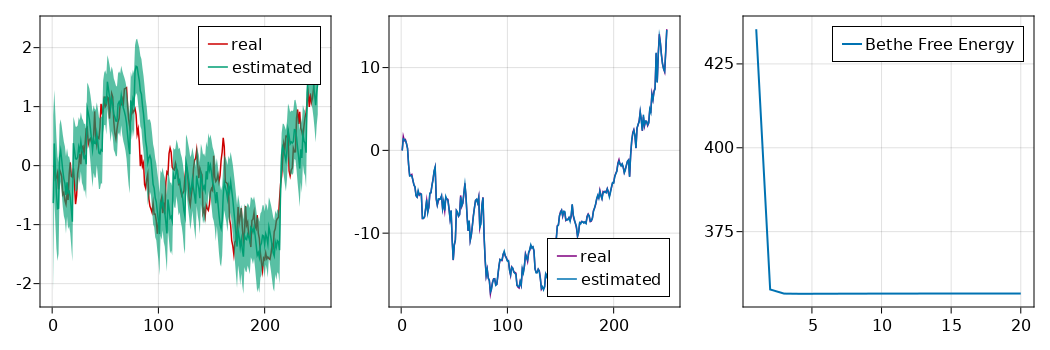

In [17]:
let 
    c = Makie.wong_colors()
    
    @unpack n, nitr = params

    f1    = Figure(resolution = (350, 350))
    f2    = Figure(resolution = (350, 350))
    f3    = Figure(resolution = (350, 350))
    range = 1:n
    grid  = 1:n

    ax1 = Makie.Axis(f1[1, 1])
    ax2 = Makie.Axis(f2[1, 1])
    ax3 = Makie.Axis(f3[1, 1])

    function plot_z(fig)

        lines!(fig, grid, z, color = :red3, label = "real")
        lines!(fig, grid, mean.(zm[range]), color = c[3], label = "estimated")
        band!(fig, grid, 
            mean.(zm) .- std.(zm),
            mean.(zm) .+ std.(zm),
            color = (c[3], 0.65)
        )

        axislegend(fig, labelsize = 16, position = :rt)
    end

    function plot_s(fig)

        lines!(fig, grid, s, color = :purple, label = "real")
        lines!(fig, grid, mean.(sm[range]), color = c[1], label = "estimated")
        band!(fig, grid, 
            mean.(sm) .- std.(sm),
            mean.(sm) .+ std.(sm),
            color = (c[1], 0.65)
        )

        axislegend(fig, labelsize = 16, position = :rb)
    end

    local rfe = vec(sum(reshape(fe, (nitr, n)), dims = 2))

    function plot_fe(fig)
        lines!(fig, 1:length(rfe), rfe, linewidth = 2, label = "Bethe Free Energy")
        axislegend(fig, labelsize = 16)
    end

    plot_z(ax1)
    plot_s(ax2)
    plot_fe(ax3)

    @saveplot f1 "hgf_inference_z"
    @saveplot f2 "hgf_inference_s"
    @saveplot f3 "hgf_inference_fe"

    local af = Figure(resolution = (350 * 3, 350))

    plot_z(Makie.Axis(af[1, 1]))
    plot_s(Makie.Axis(af[1, 2]))
    plot_fe(Makie.Axis(af[1, 3]))
    
    @show average_mse(z, zm)
    @show average_mse(s, sm)

    af
end

### Benchmark 

In [11]:
function run_benchmark(params)
    @unpack n, nitr, gh_n, seed, τ_z, τ_y, κ, ω = params

    z, s, y = generate_data(HGFModel(), params);

    fe, zm, sm = inference(y, params);
    benchmark  = @benchmark inference($y, $params);
    
    z_amse = average_mse(z, zm)
    s_amse = average_mse(s, sm)

    output = @strdict n nitr gh_n seed τ_z τ_y κ ω fe zm sm benchmark z_amse s_amse

    return output
end

run_benchmark (generic function with 1 method)

In [12]:
benchmark_params = dict_list(Dict(
    "n"     => [ 50, 100, 250, 500, 750, 1000, 1500, 2000, 5_000, 10_000, 20_000 ],
    "nitr"  => [ 5, 10, 15, 20 ],
    "seed"  => 12,
    "τ_z"   => 20.0,
    "τ_y"   => 5.0,
    "κ"     => 1.0,
    "ω"     => 0.0,	
    "gh_n"  => 9
));

In [ ]:
# First run maybe slow, you may track the progress in the terminal
# Subsequent runs will not create new benchmarks 
# but will reload it from data folder
hgf_benchmarks = map(benchmark_params) do params
    path = datadir("benchmark", "hgf", "filtering")
    result, _ = produce_or_load(path, params; tag = false) do p
        run_benchmark(p)
    end
    return result
end;

┌ Info: File /Users/isenoz/Documents/Phd/ReactiveMPPaperExperiments/data/benchmark/hgf/filtering/gh_n=9_n=50_nitr=5_seed=12_κ=1.0_τ_y=5.0_τ_z=20.0_ω=0.0.jld2 does not exist. Producing it now...
└ @ DrWatson /Users/isenoz/.julia/packages/DrWatson/OgRKj/src/saving_files.jl:61
┌ Info: File /Users/isenoz/Documents/Phd/ReactiveMPPaperExperiments/data/benchmark/hgf/filtering/gh_n=9_n=50_nitr=5_seed=12_κ=1.0_τ_y=5.0_τ_z=20.0_ω=0.0.jld2 saved.
└ @ DrWatson /Users/isenoz/.julia/packages/DrWatson/OgRKj/src/saving_files.jl:70
┌ Info: File /Users/isenoz/Documents/Phd/ReactiveMPPaperExperiments/data/benchmark/hgf/filtering/gh_n=9_n=50_nitr=10_seed=12_κ=1.0_τ_y=5.0_τ_z=20.0_ω=0.0.jld2 does not exist. Producing it now...
└ @ DrWatson /Users/isenoz/.julia/packages/DrWatson/OgRKj/src/saving_files.jl:61
┌ Info: File /Users/isenoz/Documents/Phd/ReactiveMPPaperExperiments/data/benchmark/hgf/filtering/gh_n=9_n=50_nitr=10_seed=12_κ=1.0_τ_y=5.0_τ_z=20.0_ω=0.0.jld2 saved.
└ @ DrWatson /Users/isenoz/.julia/pac

In [ ]:
target_seed = 12
target_nitr = 20

In [ ]:
let
    path = datadir("benchmark", "hgf", "filtering")

    white_list   = [ "n", "seed", "nitr", "z_amse", "s_amse" ]
    special_list = [
        :min => (data) -> string(round(minimum(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :mean => (data) -> string(round(mean(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :gctime => (data) -> string(round(minimum(data["benchmark"]).gctime / minimum(data["benchmark"]).time * 100, digits = 2), "%"),
    ]

    df = collect_results(path, white_list = white_list, special_list = special_list, verbose = false)

    query = @from row in df begin
        @where row.seed == target_seed && row.nitr == target_nitr
        @orderby ascending(row.n)
        @select { row.n, row.min, row.gctime, row.z_amse, row.s_amse }
    end

    DataFrame(query) 
end

In [16]:
target_n_itrs = [ 5, 10, 15, 20 ]

InterruptException: InterruptException:

In [ ]:
let
    local fig = Figure(resolution = (500, 350))

    local ax = Makie.Axis(fig[1, 1])

    ax.xlabel = "Number of observations in dataset log-scale()"
    ax.ylabel = "Time (in ms, log-scale)"
    ax.xscale = Makie.pseudolog10
    ax.yscale = Makie.pseudolog10

    ax.xticks = (
        [ 50, 100, 200, 500, 1000, 2000, 5000, 10_000 ], 
        [ "50", "100", "200", "500", "1e3", "2e3", "5e3", "1e4" ]
    )

    ax.yticks = (
        [ 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5_000, 10_000 ], 
        [ "5", "10", "20", "50", "100", "200", "500", "1e3", "2e3", "5e3", "1e4" ]
    )

    local mshapes = [ :utriangle, :diamond, :pentagon ]

    for (mshape, target_n_itr) in zip(mshapes, target_n_itrs)
        local filtered = filter(hgf_benchmarks) do b
            return b["nitr"] === target_n_itr
        end

        local range      = map(f -> f["n"], filtered)
        local benchmarks = map(f -> f["benchmark"], filtered)
        local timings    = map(t -> t.time, minimum.(benchmarks)) ./ 1_000_000

        lines!(ax, range, timings, label = "VMP n_itr = $(target_n_itr)")
        scatter!(ax, range, timings, marker = mshape, markersize = 16)
    end

    axislegend(ax, labelsize = 16, position = :lt)

    @saveplot fig "hgf_benchmark_observations"
end

In [18]:
target_ns = [ 500, 5000, 20000 ]

InterruptException: InterruptException:

In [19]:
begin
    local fig = Figure(resolution = (500, 350))

    local ax = Makie.Axis(fig[1, 1])

    ax.xlabel = "Number of performed VMP iterations (log-scale)"
    ax.ylabel = "Time (in ms, log-scale)"
    ax.xscale = Makie.pseudolog10
    ax.yscale = Makie.pseudolog10

    ax.xticks = (
        [ 5, 10, 15, 20 ],
        string.([ 5, 10, 15, 20 ])
    )

    ax.yticks = (
        [ 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5_000, 10_000, 20_000 ], 
        [ "5", "10", "20", "50", "100", "200", "500", "1e3", "2e3", "5e3", "1e4", "2e4" ]
    )

    ylims!(ax, (25, 8e4 ))

    local mshapes = [ :utriangle, :diamond, :pentagon ]

    for (mshape, target_n) in zip(mshapes, target_ns)
        local filtered = filter(hgf_benchmarks) do b
            return b["n"] === target_n
        end
        
        local range      = map(f -> f["nitr"], filtered)
        local benchmarks = map(f -> f["benchmark"], filtered)
        local timings    = map(t -> t.time, minimum.(benchmarks)) ./ 1_000_000
        
        @show timings
        local ylim       = (1e0, 10maximum(timings))

        lines!(ax, range, timings, label = "n_observations = $(target_n)")
        scatter!(ax, range, timings, marker = mshape, markersize = 16)
    end

    axislegend(ax, labelsize = 16, position = :lt)

    @saveplot fig "hgf_benchmark_iterations"
end

LoadError: InterruptException: